# meerTOD Examples

In [1]:
import numpy as np
from limTOD import (
    TODsim,
    example_scan,
    example_beam_map,
    pointing_beam_in_eq_sys,
    GDSM_sky_model,
)
import matplotlib.pyplot as plt
import healpy as hp

## Quick Start

No white noise variance is specified!! Using default value of 2.5e-6 (Dimensionless fractional noise)
Generating gain noise with parameters: f0=1.4e-05, fc=0.001, alpha=2.
Note that these 1/f noise are uncorrelated in frequencies.


100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Generated TOD shape: (3, 100)


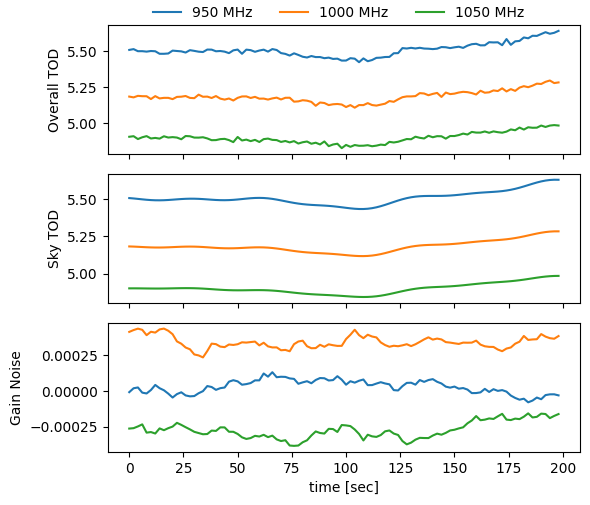

In [2]:
# Initialize the simulator with MeerKAT coordinates
simulator = TODsim(
    ant_latitude_deg=-30.7130,  # MeerKAT latitude
    ant_longitude_deg=21.4430,  # MeerKAT longitude
    ant_height_m=1054,  # MeerKAT altitude
    nside=64,  # HEALPix resolution
    beam_func=example_beam_map,
    sky_func=GDSM_sky_model
)


# Generate a simple scanning pattern
time_list, azimuth_list = example_scan()


# Simulate TOD for multiple frequencies
freq_list = [950, 1000, 1050]  # MHz
tod_array, sky_tod, gain_noise = simulator.generate_TOD(
    freq_list=freq_list,
    time_list=time_list[:100],  # Simulate only the first 100 times
    azimuth_deg_list=azimuth_list,
    elevation_deg=41.5,
)


print(f"Generated TOD shape: {tod_array.shape}")  # (3, n_time)

# Plot the results
fig, ax = plt.subplots(3, 1, figsize=(6, 5), sharex='all')
for i, f in enumerate(freq_list):
    ax[0].plot(time_list[:100], tod_array[i], c=f"C{i}", label="Overall TOD")
    ax[1].plot(time_list[:100], sky_tod[i], c=f"C{i}", label="Sky TOD")
    ax[2].plot(time_list[:100], gain_noise[i], c=f"C{i}", label="Gain Noise")
ax[0].set_ylabel("Overall TOD")
ax[1].set_ylabel("Sky TOD")
ax[2].set_ylabel("Gain Noise")
ax[2].set_xlabel("time [sec]")
fig.legend([f"{f} MHz" for f in freq_list], ncol=3, loc=(0.25, 0.95), frameon=False)
fig.tight_layout()

## Example 1: Basic TOD Simulation

In [3]:
# Initialize simulator
sim = TODsim(nside=64)  # Lower resolution for speed

# Generate scanning pattern
time_list, az_list = example_scan(dt=1.0)

# Single frequency simulation
tod, sky_tod, gain_noise = sim.generate_TOD(
    freq_list=[1000],  # 1 GHz
    time_list=time_list[:100],  # First 100 time points
    azimuth_deg_list=az_list[:100],
    elevation_deg=45.0,
)

No white noise variance is specified!! Using default value of 2.5e-6 (Dimensionless fractional noise)
Generating gain noise with parameters: f0=1.4e-05, fc=0.001, alpha=2.
Note that these 1/f noise are uncorrelated in frequencies.


100%|██████████| 100/100 [00:03<00:00, 25.35it/s]


## Example 2: Multi-frequency Simulation

No white noise variance is specified!! Using default value of 2.5e-6 (Dimensionless fractional noise)
Generating gain noise with parameters: f0=1e-05, fc=0.001, alpha=1.8.
Note that these 1/f noise are uncorrelated in frequencies.


100%|██████████| 50/50 [00:02<00:00, 24.85it/s]


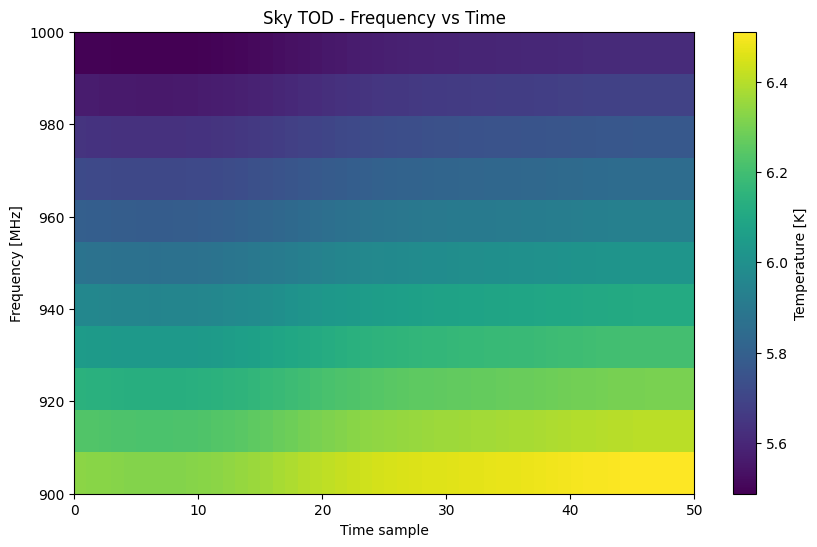

In [4]:
# Wide frequency range
frequencies = np.linspace(900, 1000, 11)  # 11 channels

tod_multifreq, sky_multifreq, _ = sim.generate_TOD(
    freq_list=frequencies,
    time_list=time_list[:50],
    azimuth_deg_list=az_list[:50],
    elevation_deg=60.0,
    gain_noise_params=[1e-5, 1e-3, 1.8],  # Custom noise parameters
)

# Plot frequency-time waterfall
plt.figure(figsize=(10, 6))
plt.imshow(
    sky_multifreq,
    aspect="auto",
    origin="lower",
    extent=[0, len(time_list[:50]), frequencies[0], frequencies[-1]],
)
plt.colorbar(label="Temperature [K]")
plt.xlabel("Time sample")
plt.ylabel("Frequency [MHz]")
plt.title("Sky TOD - Frequency vs Time")
plt.show()

## Example 3: Custom Beam and Sky Models

In [5]:
def custom_beam(freq, nside):
    """Custom frequency-dependent beam"""
    # Beam size scales with frequency
    fwhm = 100 / freq  # degrees, typical radio telescope scaling
    return example_beam_map(freq, nside, FWHM_major=fwhm, FWHM_minor=fwhm * 0.8)


def point_source_sky(freq, nside):
    """Sky with a single point source"""
    npix = hp.nside2npix(nside)
    sky = np.zeros(npix)

    # Add point source at specific coordinates
    ra, dec = 180.0, -30.0  # degrees
    theta = np.pi / 2 - np.radians(dec)
    phi = np.radians(ra)

    ipix = hp.ang2pix(nside, theta, phi)
    sky[ipix] = 100.0  # 100 K source

    return sky


# Use custom models
sim_custom = TODsim(beam_func=custom_beam, sky_func=point_source_sky, nside=64)

sim_gauss = TODsim(beam_func=example_beam_map, sky_func=point_source_sky, nside=64)

frequencies = [900, 1000, 1100]
# Simulate with custom models
tod_custom, _, _ = sim_custom.generate_TOD(
    freq_list=frequencies,
    time_list=time_list[:100],
    azimuth_deg_list=az_list,
    elevation_deg=50.0,
)

tod_gauss, _, _ = sim_custom.generate_TOD(
    freq_list=frequencies,
    time_list=time_list[:100],
    azimuth_deg_list=az_list,
    elevation_deg=50.0,
)

No white noise variance is specified!! Using default value of 2.5e-6 (Dimensionless fractional noise)
Generating gain noise with parameters: f0=1.4e-05, fc=0.001, alpha=2.
Note that these 1/f noise are uncorrelated in frequencies.


100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


No white noise variance is specified!! Using default value of 2.5e-6 (Dimensionless fractional noise)
Generating gain noise with parameters: f0=1.4e-05, fc=0.001, alpha=2.
Note that these 1/f noise are uncorrelated in frequencies.


100%|██████████| 100/100 [00:04<00:00, 23.94it/s]


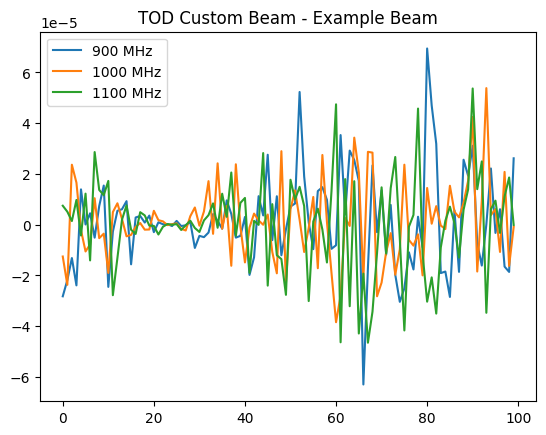

In [6]:
plt.figure()
for i, f in enumerate(frequencies):
    plt.plot(time_list[:100], tod_custom[i] - tod_gauss[i], label=f"{f} MHz")
plt.legend()
plt.title("TOD Custom Beam - Example Beam")
plt.show()

## Example 4: Creating asymmetric eliptical beam

<Figure size 640x480 with 0 Axes>

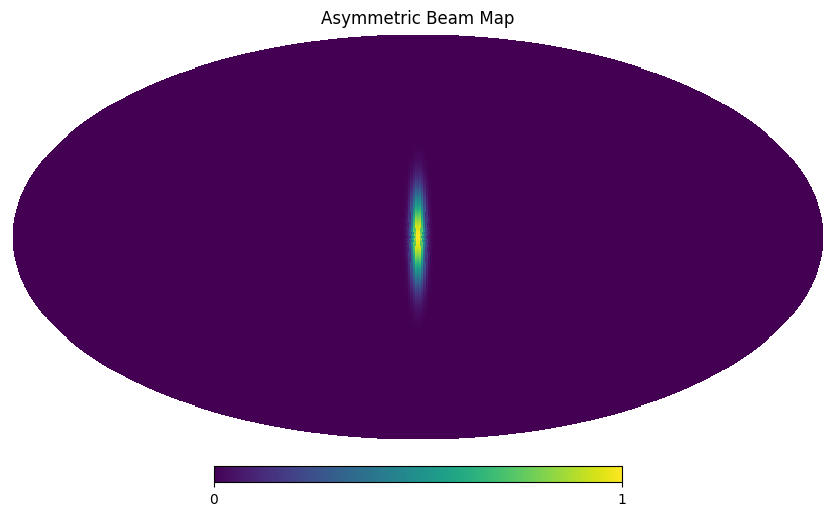

In [7]:
asym_beam = example_beam_map(900, FWHM_major=25, FWHM_minor=5, nside=64)
# Visualize the beam map
plt.figure()
hp.mollview(asym_beam, rot=(0, 90), title="Asymmetric Beam Map")
plt.show()

The helper function `pointing_beam_in_eq_sys` can be used to rotate beam 

<Figure size 640x480 with 0 Axes>

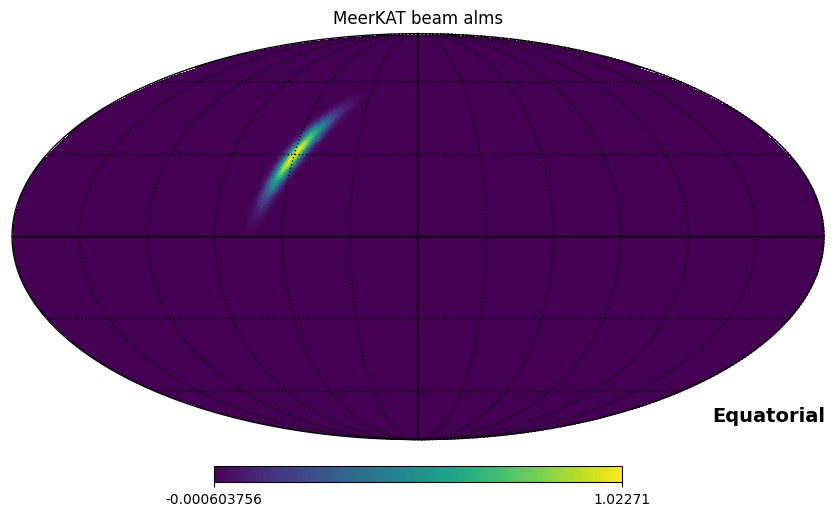

In [8]:
# Pointed Beam Specifications
LST_deg = 60  # degrees
lat_deg = 30  # degrees
azimuth_deg = 30  # degrees
elevation_deg = 90  # degrees
beam_alm = hp.map2alm(asym_beam)
pointed_beam = pointing_beam_in_eq_sys(
    beam_alm, LST_deg, lat_deg, azimuth_deg, elevation_deg, nside=64
)

plt.figure()
hp.mollview(pointed_beam, title="MeerKAT beam alms", coord="C")
hp.graticule()
plt.show()